# ML/Prepare Data
Notebook dedicado a extraer datos de simulación y organizarlos en pd.DataFrames y estudiar la correlación de las features de entrenamiento


In [1]:
import uproot
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

import seaborn as sn
import pandas as pd 

from sklearn.preprocessing import RobustScaler, normalize

In [2]:
def magnitude(vector): 
    #Funcion para calcular radio de eventos al centro del detector
    
    norm = []
    for vec in vector:
    	norm.append(np.linalg.norm(vec))

    return np.array(norm, dtype = np.float32)

# 1 - Extraer datos

In [9]:
# Archivo de Neutrinos Solares
solar_file = uproot.open("/snoplus simulations/solar_nu/High Stat/split_2_simu_Analysis_solar_Nue.root")
solar_file.keys()

['T;61', 'T;60', 'pmt;2', 'pmt;1']

In [ ]:
# Archivo de Ruido (Talio)
tl_file = uproot.open("/snoplus simulations/talio/High Stat/split_1_simu_Analysis_Tl.root")
tl_file.keys()

In [12]:
solar_data = solar_file['T;61']
tl_data = tl_file['T;74']
pmt_info = tl_file['pmt;1']

## 1.1 - PMT info

In [13]:
pmt_id = np.array(pmt_info['pmt_id'], dtype = np.int16)
pmt_pos_xyz = np.array(pmt_info['pmt_pos_xyz'])
pmt_pos_sph = np.array(pmt_info['pmt_pos_sph'])
pmt_type = np.array(pmt_info['pmt_type'], dtype = np.int16)

## 1.2 - Solar Variables

In [14]:
solar_data.keys()

['evtid',
 'mcID',
 'energy',
 'mc_position',
 'mc_momentum',
 'position',
 'momentum',
 'hit_pmtid',
 'hit_pmttime',
 'hit_residual',
 'hit_type']

In [15]:
solar_mcID = np.array(solar_data['mcID'], dtype = np.int16)#[:solar_limit]
solar_energy = np.array(solar_data['energy'], dtype = np.float32)#[:solar_limit]
solar_mc_position = np.array(solar_data['mc_position'])#[:solar_limit]   #-> Position Generation
solar_mc_momentum = np.array(solar_data['mc_momentum'])#[:solar_limit]   #-> IMPORTANT: Direction of simulated event
solar_position = np.array(solar_data['position'])#[:solar_limit]        
solar_hit_pmtid = np.array(solar_data['hit_pmtid'], dtype = np.int16)#[:solar_limit]
solar_time_residual = np.array(solar_data['hit_residual'])#[:solar_limit]
solar_hit_type = np.array(solar_data['hit_type'], dtype = np.int16)#[:solar_limit]

## 1.3 - Tálio Variables

In [ ]:
tl_mcID = np.array(tl_data['mcID'], dtype = np.int16)#[:tl_limit]
tl_energy = np.array(tl_data['energy'], dtype = np.float32)#[:tl_limit]
tl_mc_position = np.array(tl_data['mc_position'])#[:tl_limit]   #-> Position Generation
tl_mc_momentum = np.array(tl_data['mc_momentum'])#[:tl_limit]   #-> IMPORTANT: Direction of simulated event
tl_position = np.array(tl_data['position'])#[:tl_limit]        
tl_hit_pmtid = np.array(tl_data['hit_pmtid'], dtype = np.int16)#[:tl_limit]
tl_time_residual = np.array(tl_data['hit_residual'])#[:tl_limit]
tl_hit_type = np.array(tl_data['hit_type'], dtype = np.int16)#[:tl_limit]

## 1.3 - Numero de Eventos de Simulación

### 1.3.1 - Nº Tl

In [ ]:
tl_break_i = [0]
tl_N_data = len(tl_mcID)

for tl_i in range(tl_N_data-1):
    if tl_mcID[tl_i] != tl_mcID[tl_i+1]:
        tl_break_i.append(tl_i+1)

tl_break_i = np.array(tl_break_i)

N_tl_evs = len(tl_break_i)

print('Tl events:', N_tl_evs)

### 1.3.2 - Nº solar_nu

In [16]:
solar_break_i = [0]

solar_N_data = len(solar_mcID)

for solar_i in range(solar_N_data-1):
    if solar_mcID[solar_i] != solar_mcID[solar_i+1]:
        solar_break_i.append(solar_i+1)

solar_break_i = np.array(solar_break_i)

N_solar_evs = len(solar_break_i)

print('Solar events:', N_solar_evs)

Solar events: 142427


# * Espectro de Energia y Radio de Eventos de Simulación

### * Cortes de Calidad (volumen)

In [37]:
#Extract unique Data
uni_solar_en = []
uni_solar_pos = []

uni_tl_en = []
uni_tl_pos = []

for i in solar_break_i:
    uni_solar_en.append(solar_energy[i])
    uni_solar_pos.append(solar_position[i])
    
for j in tl_break_i:
    uni_tl_en.append(tl_energy[j])
    uni_tl_pos.append(tl_position[j])


uni_solar_en = np.array(uni_solar_en)
uni_solar_pos = np.array(uni_solar_pos)
uni_solar_rad = magnitude(uni_solar_pos)

uni_tl_en = np.array(uni_tl_en)
uni_tl_pos = np.array(uni_tl_pos)
uni_tl_rad = magnitude(uni_tl_pos)

#Cuts (energy and volume)
min_energy = 0.5
max_rad = 5500.0

uni_solar_en_cut = []
uni_solar_rad_cut = []

uni_tl_en_cut = []
uni_tl_rad_cut = []

for i in np.where((uni_solar_rad < max_rad) & (uni_solar_en > min_energy))[0]:
    uni_solar_en_cut.append(uni_solar_en[i])
    uni_solar_rad_cut.append(uni_solar_rad[i])

for j in np.where((uni_tl_rad < max_rad) & (uni_tl_en > min_energy))[0]:
    uni_tl_en_cut.append(uni_tl_en[j])
    uni_tl_rad_cut.append(uni_tl_rad[j])

uni_solar_en_cut = np.array(uni_solar_en_cut)
uni_solar_rad_cut = np.array(uni_solar_rad_cut)

uni_tl_en_cut = np.array(uni_tl_en_cut)
uni_tl_rad_cut = np.array(uni_tl_rad_cut)

all_energy = np.concatenate((uni_solar_en_cut, uni_tl_en_cut))

In [38]:
len(uni_solar_en)

302209

In [39]:
len(uni_tl_en)

159817

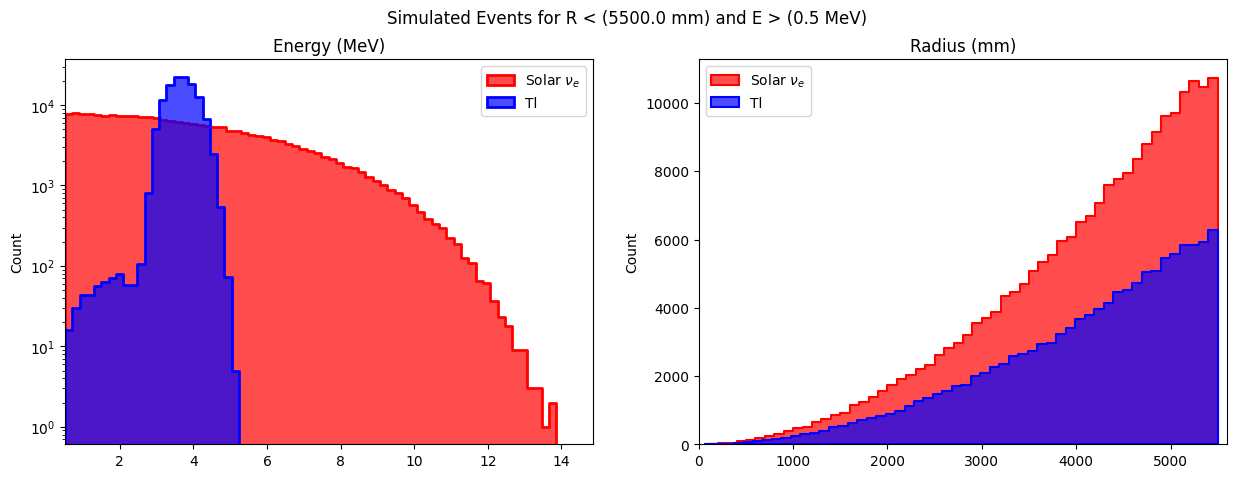

In [40]:
binwidth_en = 0.2
alpha_en = 0.7
linewidth_en = 2

binwidth_rad = 100
alpha_rad = 0.7
linewidth_rad = 1.5

figure, axes = plt.subplots(1,2, figsize=(15, 5))

sn.histplot(uni_solar_en_cut, binwidth = binwidth_en, color = 'r', label = 'Solar $ν_e$', common_bins = True, 
            alpha = alpha_en, linewidth = linewidth_en, element = 'step', kde=False, ax = axes[0])
sn.histplot(uni_tl_en_cut, binwidth = binwidth_en, color = 'b', label = 'Tl', common_bins = True, 
            alpha = alpha_en, linewidth = linewidth_en, element = 'step', kde=False, ax = axes[0])

sn.histplot(uni_solar_rad_cut, binwidth = binwidth_rad, color = 'r', label = 'Solar $ν_e$', common_bins = True, 
            alpha = alpha_rad, linewidth = linewidth_rad, element = 'step', kde=False, ax = axes[1])
sn.histplot(uni_tl_rad_cut, binwidth = binwidth_rad, color = 'b', label = 'Tl', common_bins = True, 
            alpha = alpha_rad, linewidth = linewidth_rad, element = 'step', kde=False, ax = axes[1])


axes[0].set_title('Energy (MeV)')
axes[1].set_title('Radius (mm)')

axes[0].legend()
axes[1].legend(loc = 'upper left')

axes[0].set_yscale('log')

axes[0].set_xlim(np.min(all_energy), np.max(all_energy) + 1)
axes[1].set_xlim(0,5600)

plt.suptitle('Simulated Events for R < ('+str(max_rad)+' mm) and E > ('+str(min_energy)+' MeV)')
#plt.savefig('figs/First Model/10x10/Data/simulated_data_(E,R).png', format = 'png', bbox_inches = 'tight')

# 2 - Select Valid Data

Select only hits that verify pmt_type = 1

In [18]:
valid_pmt_id = np.array(np.where(pmt_type == 1)[0]) # PMT valid ID match with index where pmt_type=1

#extract valid indices in data
solar_valid_id_info_i = np.array(np.where(np.in1d(solar_hit_pmtid, valid_pmt_id))[0])
tl_valid_id_info__i = np.array(np.where(np.in1d(tl_hit_pmtid, valid_pmt_id))[0])

#extract coordinates of pmt_type = 1
valid_pmt_xyz = []   #List of valid PMT coordinates (type 1)
for i_dx in valid_pmt_id:
    valid_pmt_xyz.append(pmt_pos_xyz[i_dx])
valid_pmt_xyz = np.array(valid_pmt_xyz)

In [19]:
solar_valid_id_info_i

array([        0,         1,         2, ..., 122394642, 122394643,
       122394644], dtype=int64)

# 3 - Process Data

Procesamiento de datos (corte en volumen, energia y tiempo), calculo de observable cos(α)

## 3.1 - Ajuste de Procesamiento

El ajuste será aplicado a simulaciones de Tálio y de neutrinos Solares

In [14]:
#params to adjust the cuts--------------------------------------------
#Split Data
split = 20

#energy cut
inf_en_cut = 5
up_en_cut = 14

#time cut (ns)
inf_cut = -5.0
up_cut = 7.0

#radial cut
radi_cut_method = True   #If true, apply radial cuts given by rad_cut_val to data
rad_cut_val = 5500.0   # Buen valor de corte para observar una identificación efizas de neutrinos solares
#--------------------------------------------------------------------------

### 3.1.1 - Procesamiento de Solares

In [15]:
# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(solar_valid_id_info_i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
solar_multi_time_residual_cut = []
solar_multi_cos_angle_cut = []
#multi_position_cut = []
solar_multi_mc_momentum_cut = []
solar_multi_mc_ID_cut = []
solar_multi_energy_cut = []
solar_multi_radi_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_radi = []
    multi_energy = []
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_energy.append(solar_energy[valid_i])
        multi_mc_ID.append(solar_mcID[valid_i])
        multi_time_residual.append(solar_time_residual[valid_i])
        multi_pmt_id_hit.append(solar_hit_pmtid[valid_i])
        multi_position.append(solar_position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(solar_mc_momentum[valid_i])
    multi_energy = np.array(multi_energy)
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #energy_cut:
    print('In energy cut')
    condition_en_cut = (multi_energy > inf_en_cut) & (multi_energy < up_en_cut)
    
    #variables to extract
    multi_energy = np.extract(condition_en_cut, multi_energy)
    multi_mc_ID = np.extract(condition_en_cut, multi_mc_ID)
    multi_time_residual = np.extract(condition_en_cut, multi_time_residual)
    multi_pmt_id_hit = np.extract(condition_en_cut, multi_pmt_id_hit)

    multi_mc_momentum_en_cut = []
    multi_position_en_cut = []
    for e_dx in np.where(condition_en_cut)[0]:
        multi_mc_momentum_en_cut.append(multi_mc_momentum[e_dx])
        multi_position_en_cut.append(multi_position[e_dx])
    multi_mc_momentum = np.array(multi_mc_momentum_en_cut)
    multi_position = np.array(multi_position_en_cut)
    #freed memory
    multi_mc_momentum_en_cut = None
    multi_position_en_cut = None
            
    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut')
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        multi_radi.append(position_norm)
        
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])
        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)
        multi_energy = np.extract(radi_condition, multi_energy)
        multi_radi = np.extract(radi_condition, multi_radi)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        solar_multi_time_residual_cut.append(multi_time_residual[i])
        solar_multi_cos_angle_cut.append(multi_cos_angle[i])
        #solar_multi_position_cut.append(multi_position[i])
        solar_multi_mc_momentum_cut.append(multi_mc_momentum[i])
        solar_multi_mc_ID_cut.append(multi_mc_ID[i])
        solar_multi_energy_cut.append(multi_energy[i])
        solar_multi_radi_cut.append(multi_radi[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    multi_energy = None
    multi_radi = None

#multi_position_cut = np.array(multi_position_cut)
solar_multi_mc_momentum_cut = np.array(solar_multi_mc_momentum_cut)
solar_multi_mc_ID_cut = np.array(solar_multi_mc_ID_cut, dtype = np.int16)
solar_multi_energy_cut = np.array(solar_multi_energy_cut)
solar_multi_radi_cut = np.array(solar_multi_radi_cut)

slipt nº: 0
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 1
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 2
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 3
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 4
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 5
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 6
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 7
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 8
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 9
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 10
In energy cut
In radi_cut
computing cos(alpha)
doing time residual cuts
slipt nº: 11
In energy cut
In radi_cut
computing cos(alpha)
doing time resi

### 3.1.2 - Procesamiento de Tálio

In [ ]:
# Dividir valid_id_info_ev_i en partes
valid_info_ev_split = np.array_split(tl_valid_id_info__i, split)  #---> split(array, parts)

#variables to save: with time residual cuts and radi cut (radi cut is optional, depends on the simulation)
tl_multi_time_residual_cut = []
tl_multi_cos_angle_cut = []
#multi_position_cut = []
tl_multi_mc_momentum_cut = []
tl_multi_mc_ID_cut = []
tl_multi_energy_cut = []
tl_multi_hit_xyz_cut = []  #save the coordinates of hits to be used to generate the background with (random direction != mc_momentum)
tl_multi_radi_cut = []

#loop over valid_info_ev_split
for n_loop, split_array in enumerate(valid_info_ev_split):
    print('slipt nº:', n_loop)
    # extract all valid simulated info 
    multi_radi = []
    multi_energy = []
    multi_mc_ID = []
    multi_time_residual = []
    multi_pmt_id_hit = []
    multi_position = []
    #multi_mc_position = []
    multi_mc_momentum = []   
    multi_xyz_hit = []

    for valid_i in split_array:
        multi_energy.append(tl_energy[valid_i])
        multi_mc_ID.append(tl_mcID[valid_i])
        multi_time_residual.append(tl_time_residual[valid_i])
        multi_pmt_id_hit.append(tl_hit_pmtid[valid_i])
        multi_position.append(tl_position[valid_i])
        #multi_mc_position.append(mc_position[valid_i])
        multi_mc_momentum.append(tl_mc_momentum[valid_i])
    multi_energy = np.array(multi_energy)
    multi_time_residual = np.array(multi_time_residual)
    multi_pmt_id_hit = np.array(multi_pmt_id_hit)
    multi_position = np.array(multi_position)

    for id_i in multi_pmt_id_hit:
        multi_xyz_hit.append(pmt_pos_xyz[id_i])
    multi_xyz_hit = np.array(multi_xyz_hit)

    #energy_cut:
    print('In energy cut')
    condition_en_cut = (multi_energy > inf_en_cut) & (multi_energy < up_en_cut)
    
    #variables to extract
    multi_energy = np.extract(condition_en_cut, multi_energy)
    multi_mc_ID = np.extract(condition_en_cut, multi_mc_ID)
    multi_time_residual = np.extract(condition_en_cut, multi_time_residual)
    multi_pmt_id_hit = np.extract(condition_en_cut, multi_pmt_id_hit)

    multi_mc_momentum_en_cut = []
    multi_position_en_cut = []
    for e_dx in np.where(condition_en_cut)[0]:
        multi_mc_momentum_en_cut.append(multi_mc_momentum[e_dx])
        multi_position_en_cut.append(multi_position[e_dx])
    multi_mc_momentum = np.array(multi_mc_momentum_en_cut)
    multi_position = np.array(multi_position_en_cut)
    #freed memory
    multi_mc_momentum_en_cut = None
    multi_position_en_cut = None
            
    #Radial Cut:
    if radi_cut_method == True:
        print('In radi_cut')
        #mc_position_norm = magnitude(multi_mc_position)
        position_norm = magnitude(multi_position)
        multi_radi.append(position_norm)
        
        max_radi = rad_cut_val
        radi_condition = (position_norm < max_radi)
        index_cut_radi = np.array(np.where(radi_condition)[0])
        #variables to extract
        multi_time_residual = np.extract(radi_condition, multi_time_residual)
        multi_pmt_id_hit = np.extract(radi_condition, multi_pmt_id_hit)
        multi_energy = np.extract(radi_condition, multi_energy)
        multi_radi = np.extract(radi_condition, multi_radi)

        multi_mc_ID_radi_cut = []
        multi_mc_momentum_radi_cut = []
        multi_position_radi_cut = []
        multi_xyz_hit_radi_cut = [] 

        for j_dx in index_cut_radi:
            multi_mc_momentum_radi_cut.append(multi_mc_momentum[j_dx])
            multi_position_radi_cut.append(multi_position[j_dx])          #HERE
            multi_mc_ID_radi_cut.append(multi_mc_ID[j_dx])

        for id_i in multi_pmt_id_hit:
            multi_xyz_hit_radi_cut.append(pmt_pos_xyz[id_i])

        multi_mc_ID = multi_mc_ID_radi_cut
        multi_mc_momentum = multi_mc_momentum_radi_cut   #HERE
        multi_position = multi_position_radi_cut
        multi_xyz_hit = multi_xyz_hit_radi_cut
        
        #freed memory
        multi_mc_ID_radi_cut = None
        multi_mc_momentum_radi_cut = None
        multi_position_radi_cut = None
        multi_xyz_hit_radi_cut = None
        radi_condition = None
        index_cut_radi = None
        
    #cos(alpha) calculation -> Uses the definition of scalar product
    multi_cos_angle = []
    N = np.shape(multi_xyz_hit)[0]

    print('computing cos(alpha)')
    for k in range(N):
        #event_direction = np.array([0,0,-1])
        event_direction = multi_mc_momentum[k]
        scalar_product = np.dot(multi_xyz_hit[k], event_direction)
        norm_1 = np.linalg.norm(event_direction)
        norm_2 = np.linalg.norm(multi_xyz_hit[k])
        cos_val = scalar_product/(norm_1*norm_2)
        
        multi_cos_angle.append(cos_val)

    #Time residual cut:
    print('doing time residual cuts')
    for i in np.where((multi_time_residual > inf_cut) & (multi_time_residual < up_cut))[0]:
        tl_multi_time_residual_cut.append(multi_time_residual[i])
        tl_multi_cos_angle_cut.append(multi_cos_angle[i])
        #multi_position_cut.append(multi_position[i])
        tl_multi_mc_momentum_cut.append(multi_mc_momentum[i])
        tl_multi_mc_ID_cut.append(multi_mc_ID[i])
        tl_multi_energy_cut.append(multi_energy[i])
        tl_multi_hit_xyz_cut.append(multi_xyz_hit[i])
        tl_multi_radi_cut.append(multi_radi[i])

    #freed memory
    multi_cos_angle = None

    #freen memory:    
    multi_mc_ID = None
    multi_time_residual = None
    multi_pmt_id_hit = None
    multi_position = None
    multi_mc_position = None
    multi_mc_momentum = None
    multi_xyz_hit = None
    multi_energy = None

#multi_position_cut = np.array(multi_position_cut)
tl_multi_mc_momentum_cut = np.array(tl_multi_mc_momentum_cut)
tl_multi_mc_ID_cut = np.array(tl_multi_mc_ID_cut, dtype = np.int16)
tl_multi_energy_cut = np.array(tl_multi_energy_cut)
tl_multi_hit_xyz_cut = np.array(tl_multi_hit_xyz_cut)
tl_multi_radi_cut = np.array(tl_multi_radi_cut)

# 4 - Extraer Datos de Entrenamiento

Serán extraidos, evento a evento, las imagenes de la distribucion Δα y se hará la correspondencia (solar νe = 1) y (tl = 0) a cada imagen

In [ ]:
solar_break_i = [0]
tl_break_i = [0]

solar_N_data = len(solar_multi_mc_ID_cut)
tl_N_data = len(tl_multi_mc_ID_cut)

for solar_i, tl_i in zip(range(solar_N_data-1), range(tl_N_data-1)):
    if solar_multi_mc_ID_cut[solar_i] != solar_multi_mc_ID_cut[solar_i+1]:
        solar_break_i.append(solar_i+1)
    if tl_multi_mc_ID_cut[tl_i] != tl_multi_mc_ID_cut[tl_i+1]:
        tl_break_i.append(tl_i+1)

N_solar_evs = len(solar_break_i)
N_tl_evs = len(tl_break_i)

print('Nº Solar Events: ', N_solar_evs)
print('Nº Tl Events: ', N_tl_evs)

In [18]:
#Igualar nº de eventos
if N_solar_evs > tl_N_data:
    solar_break_i = solar_break_i[0:tl_N_data]

if  tl_N_data > N_solar_evs:
    tl_break_i = tl_break_i[0:N_solar_evs]

solar_break_i = np.array(solar_break_i)
tl_break_i = np.array(tl_break_i)

In [19]:
tl_break_i

array([       0,      164,      343, ..., 15427361, 15427557, 15427773])

## 4.1 - Redefinir dirección de Tálio

Substituir entradas de mc_momentum de tálio por el evID correspondiente en eventos de neutrinos solares

In [20]:
N_breaks = len(tl_break_i)

for i_dx in range(N_breaks - 1):
    i_solar = solar_break_i[i_dx]
    i_tl = tl_break_i[i_dx]
    f_tl = tl_break_i[i_dx + 1]
    
    tl_multi_mc_momentum_cut[i_tl:f_tl] = solar_multi_mc_momentum_cut[i_solar]
tl_multi_mc_momentum_cut[tl_break_i[-1]:-1] = solar_multi_mc_momentum_cut[-1]

##  4.2 - Redefinir cos(α) en Tálio

In [21]:
tl_cos_fake = []

for i_dx in range(N_breaks-1):
    i_tl = tl_break_i[i_dx]
    f_tl = tl_break_i[i_dx + 1]
    
    direction_ev = tl_multi_mc_momentum_cut[i_tl]
    pmt_xyz_hit_ev = tl_multi_hit_xyz_cut[i_tl:f_tl]
    N_hits = np.shape(pmt_xyz_hit_ev)[0]
    
    for hit_i in range(N_hits):
        pmt_xyz = pmt_xyz_hit_ev[hit_i]
        scalar_product = np.dot(pmt_xyz, direction_ev)
        norm_1 = np.linalg.norm(pmt_xyz)
        norm_2 = np.linalg.norm(direction_ev)
        cos_val = scalar_product/(norm_1*norm_2)
        tl_cos_fake.append(cos_val)
        
tl_cos_fake = np.array(tl_cos_fake)

## 4.3 - Extraer Datos para Solar $ν_e$

In [22]:
bins = 10

H_flaten_nu = []  #flatten images of solar nu evs
labels_nu = []  #save label of solar nu evs (1)
energy_nu = []
radi_nu = []

N_terms = len(solar_break_i)

for nu_i in range(N_terms - 1):
    init_nu = solar_break_i[nu_i]
    final_nu = solar_break_i[nu_i + 1]

    solar_time_res_ev = solar_multi_time_residual_cut[init_nu: final_nu]
    solar_cos_ev = solar_multi_cos_angle_cut[init_nu: final_nu]
    solar_energy_ev = solar_multi_energy_cut[init_nu]
    solar_radi_ev = solar_multi_radi_cut[init_nu]

    #COLOCAR AQUI ABAJO CORTE DE CALIDAD CASO SEA NECESARION (Nº DE REGOISTROS, ETC...)

    #raw histogram
    H_nu_ev, _, _ = np.histogram2d(x = solar_cos_ev, y =  solar_time_res_ev, bins = [bins, bins])

    #normalization by NHits
    sum_hit_nu_ev = np.sum(H_nu_ev,axis=0)
    H_nu_ev_norm = H_nu_ev/sum_hit_nu_ev
    H_nu_ev_norm = np.nan_to_num(H_nu_ev_norm, nan = 0.0)

    H_flatten_ev = H_nu_ev_norm.ravel()
    H_flaten_nu.append(H_flatten_ev)
    labels_nu.append(np.ones(len(H_flatten_ev), dtype = np.int8))
    energy_nu.append(np.ones(len(H_flatten_ev))*solar_energy_ev)
    radi_nu.append(np.ones(len(H_flatten_ev))*solar_radi_ev)

H_flaten_nu = np.array(H_flaten_nu).ravel()
labels_nu = np.array(labels_nu).ravel()
energy_nu = np.array(energy_nu).ravel()
radi_nu = np.array(radi_nu).ravel()

#Extraer imagenes Normalizadas y hacer flaten de los datos. 

C:\Users\joanc\AppData\Local\Temp\ipykernel_16428\3100496135.py:26: RuntimeWarning: invalid value encountered in divide
  H_nu_ev_norm = H_nu_ev/sum_hit_nu_ev


## 4.4 - Extraer Datos de Background Tálio

In [23]:
bins = 10

H_flaten_tl = []  #flatten images of solar nu evs
labels_tl = []  #save label of solar nu evs (1)
energy_tl = []  #save energy
radi_tl = []

N_terms = len(tl_break_i)

for tl_i in range(N_terms - 1):
    init_tl = tl_break_i[tl_i]
    final_tl = tl_break_i[tl_i + 1]

    tl_time_res_ev = tl_multi_time_residual_cut[init_tl:final_tl]
    tl_cos_ev = tl_cos_fake[init_tl:final_tl]
    energy_tl_ev = tl_multi_energy_cut[init_tl]
    radi_tl_ev = tl_multi_radi_cut[init_tl]

    #COLOCAR AQUI ABAJO CORTE DE CALIDAD CASO SEA NECESARION (Nº DE REGISTROS, ETC...)

    #raw histogram
    H_tl_ev, _, _ = np.histogram2d(x = tl_cos_ev, y =  tl_time_res_ev, bins = [bins, bins])

    #normalization by NHits
    sum_hit_tl_ev = np.sum(H_tl_ev,axis=0)
    H_tl_ev_norm = H_tl_ev/sum_hit_tl_ev
    H_tl_ev_norm = np.nan_to_num(H_tl_ev_norm, nan = 0.0)

    H_flatten_tl_ev = H_tl_ev_norm.ravel()
    H_flaten_tl.append(H_flatten_tl_ev)
    labels_tl.append(np.zeros(len(H_flatten_tl_ev), dtype = np.int8))
    energy_tl.append(np.ones(len(H_flatten_tl_ev))*energy_tl_ev) #construct a dimensional correct array with energy of event
    radi_tl.append(np.ones(len(H_flatten_tl_ev))*radi_tl_ev)

H_flaten_tl = np.array(H_flaten_tl).ravel()
labels_tl = np.array(labels_tl).ravel()
energy_tl = np.array(energy_tl).ravel()
radi_tl = np.array(radi_tl).ravel()

#Extraer imagenes Normalizadas y hacer flaten de los datos. 

C:\Users\joanc\AppData\Local\Temp\ipykernel_16428\3335357884.py:26: RuntimeWarning: invalid value encountered in divide
  H_tl_ev_norm = H_tl_ev/sum_hit_tl_ev


# 5 - Organizar los Datos:

Crear un PandasDataFrame que guarde los pixeles y su Label. Guardar DataFrame como archivo csv

In [24]:
len(H_flaten_tl)

8679900

In [25]:
len(labels_tl)

8679900

In [26]:
all_pixels = np.concatenate((H_flaten_nu, H_flaten_tl))
all_labels = np.concatenate((labels_nu, labels_tl))
all_energy = np.concatenate((energy_nu, energy_tl))
all_radi = np.concatenate((radi_nu, radi_tl))

data = {'pixel value': all_pixels,
       'labels': all_labels,
        'energy (MeV)': all_energy,
        'event radius (mm)': all_radi,
        }

df = pd.DataFrame(data)
df

,pixel value,labels,energy (MeV),event radius (mm)
0,0.000000,1,4.140509,4953.780762
1,0.000000,1,4.140509,4953.780762
2,0.000000,1,4.140509,4953.780762
3,0.214286,1,4.140509,4953.780762
4,0.142857,1,4.140509,4953.780762
...,...,...,...,...
17359795,0.000000,0,3.653474,5148.583496
17359796,0.022222,0,3.653474,5148.583496
17359797,0.000000,0,3.653474,5148.583496
17359798,0.093750,0,3.653474,5148.583496


In [27]:
df.to_csv("Data/High Stat/df_5500_10_(2.5_14)_(-5_7).csv")

# 6 - Observar y Representar Datos

In [28]:
df_read = pd.read_csv("Data/High Stat/df_5500_10_(2.5_14)_(-5_7).csv").drop(columns = ['Unnamed: 0'])

In [29]:
df_read

,pixel value,labels,energy (MeV),event radius (mm)
0,0.000000,1,4.140509,4953.780762
1,0.000000,1,4.140509,4953.780762
2,0.000000,1,4.140509,4953.780762
3,0.214286,1,4.140509,4953.780762
4,0.142857,1,4.140509,4953.780762
...,...,...,...,...
22795195,0.000000,0,3.946869,3842.177979
22795196,0.181818,0,3.946869,3842.177979
22795197,0.125000,0,3.946869,3842.177979
22795198,0.136364,0,3.946869,3842.177979


In [30]:
df_read.describe()

,pixel value,labels,energy (MeV),event radius (mm)
count,2.279520e+07,22795200.0,2.279520e+07,2.279520e+07
mean,9.774088e-02,0.5,3.784584e+00,4.100289e+03
std,1.445464e-01,0.5,1.719554e+00,1.070698e+03
min,0.000000e+00,0.0,5.000694e-01,6.875449e+01
25%,0.000000e+00,0.0,3.079932e+00,3.428651e+03
50%,5.000000e-02,0.5,3.652838e+00,4.338067e+03
75%,1.428571e-01,1.0,4.203391e+00,4.976620e+03
max,1.000000e+00,1.0,1.354674e+01,5.499991e+03


<Axes: xlabel='event radius (mm)', ylabel='Count'>

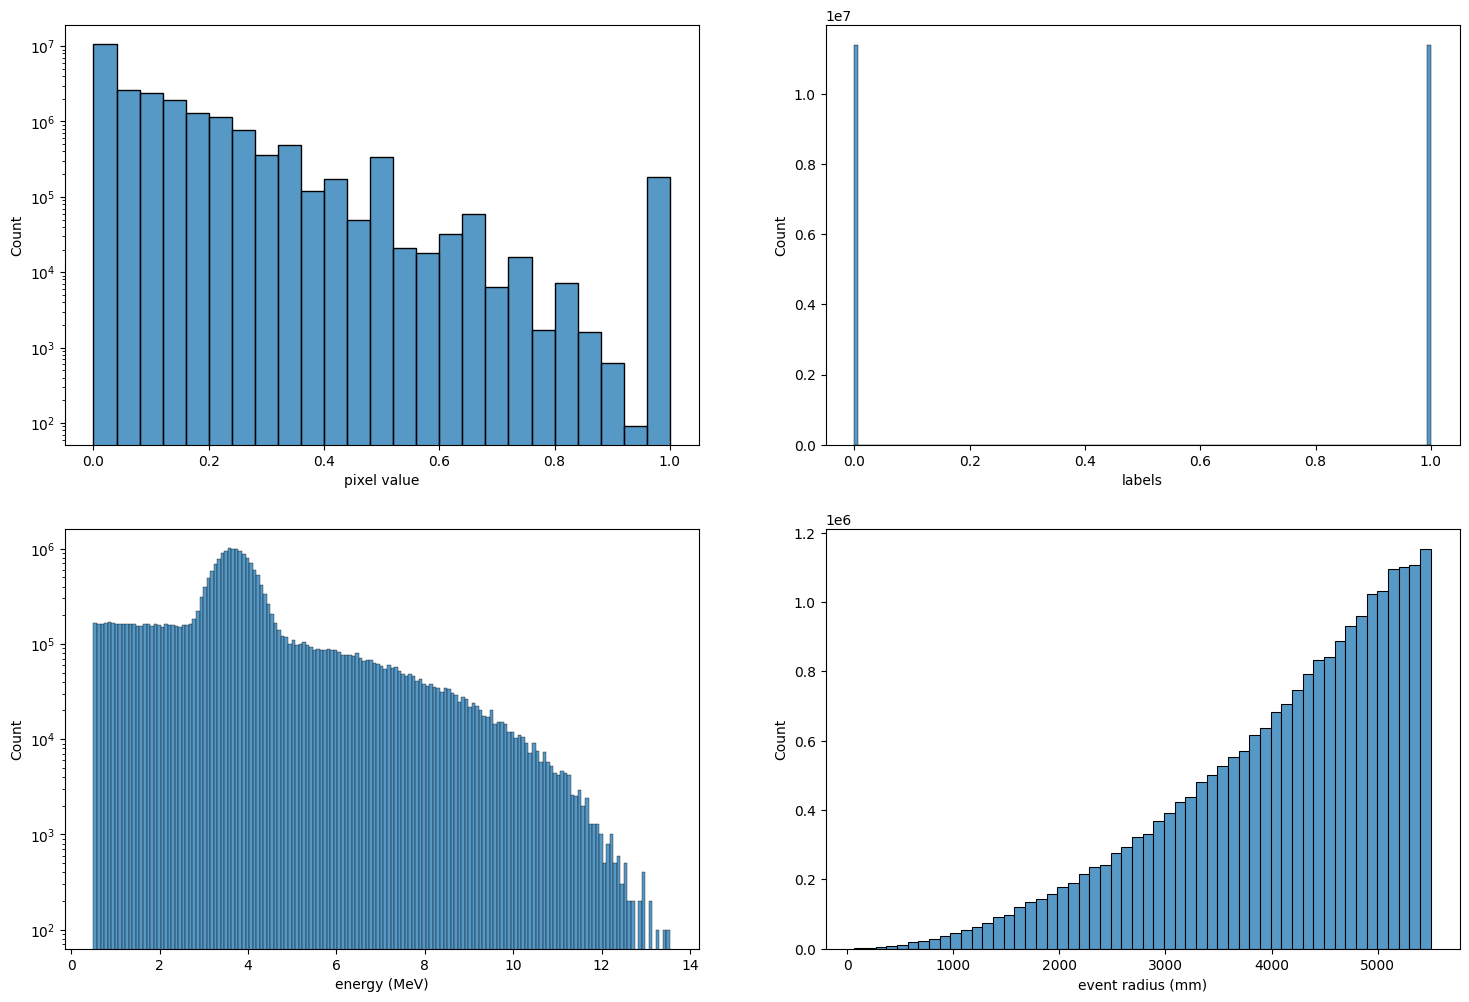

In [31]:
fig, axes = plt.subplots(2, 2,  figsize=(18, 12))

sn.histplot(data = df_read['pixel value'] , bins = 25, log = True, ax=axes[0,0])
sn.histplot(data = df_read['energy (MeV)'] , binwidth = 0.08, log = True ,ax=axes[1,0])
sn.histplot(data = df_read['labels'], ax=axes[0,1])
sn.histplot(data = df_read['event radius (mm)'], binwidth = 100 ,ax=axes[1,1])
#plt.savefig('figs/First Model/10x10/Data/data_set_representation.png', format = 'png', bbox_inches = 'tight')


## 6.1 - Separar Signal vs. Background

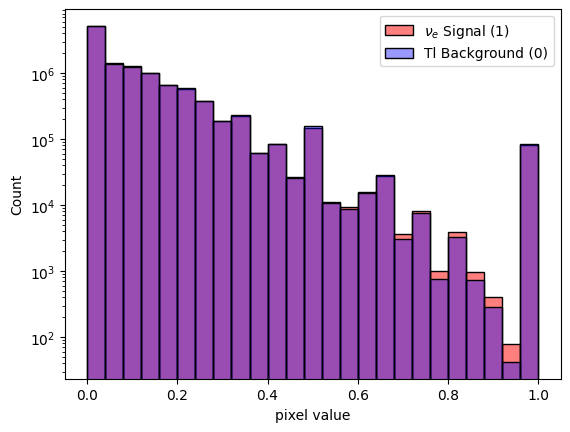

In [37]:
#Separate data set by labels
solar_signal = df_read[df_read['labels'] == 1]
tl_bkg = df_read[df_read['labels'] == 0]

#plot
bins = 25
sn.histplot(data = solar_signal['pixel value'], bins = bins, log = True, alpha = 0.5, color = 'r', label = '$ν_e$ Signal (1)')
sn.histplot(data = tl_bkg['pixel value'], bins = bins, log = True, alpha = 0.4, color = 'b', label = 'Tl Background (0)')
plt.legend()

#plt.savefig('figs/High Stat/pixel_values_compare.png', format = 'png', bbox_inches = 'tight')

# 6.2 - Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

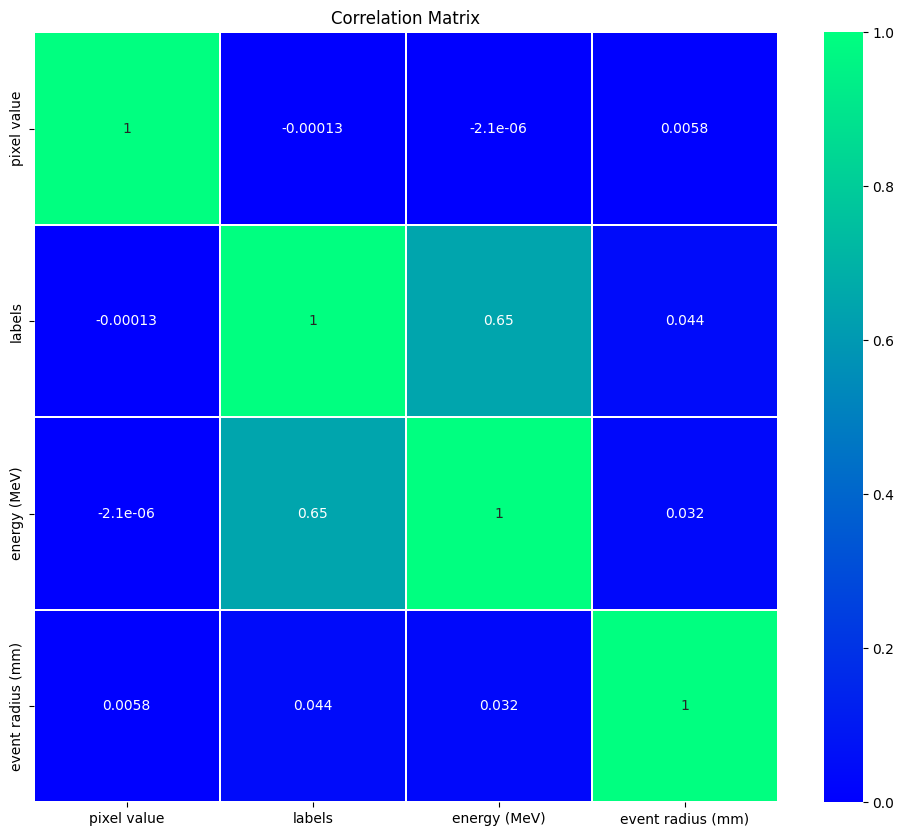

In [41]:
plt.figure(figsize=(12,10))
sn.heatmap(df_read.corr(), cmap='winter', annot = True, linewidths= 0.1)
plt.title('Correlation Matrix', fontsize = '12')
#plt.savefig('figs/High Stat/correlation_matrix.png', format = 'png')

#Styles: PuBu, winter

### 6.2.1 - Correlation Between each Pixel, Energy and Radi

### Separe Energy and Radi to get one value for each event

In [29]:
image_shape = (10,10)
image_dim = image_shape[0]*image_shape[1]

single_en =  []
single_rad = []

energy = df_read['energy (MeV)']
radi = df_read['event radius (mm)']

split_en = np.array(np.split(energy, len(energy) // image_dim))
split_rad = np.array(np.split(radi, len(radi) // image_dim))

N_evs = split_en.shape[0]

for i in range(N_evs):
    single_en.append(split_en[i][0])
    single_rad.append(split_rad[i][0])
    
single_en = np.array(single_en)
single_rad = np.array(single_rad)

C:\Users\joanc\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


In [30]:
single_en

array([4.14050913, 5.14862728, 3.04888821, ..., 3.49498105, 3.13200021,
       3.65347409])

### Construct DataSet with Pixel values

Join the pixels in the same position of diferentes events an see their correlations

In [31]:
image_shape = (10,10)
image_dim = image_shape[0]*image_shape[1]

pixels = df_read['pixel value'].to_numpy()
split_pixels = np.array(np.split(pixels, len(pixels) // image_dim))

N_pixel = split_pixels.shape[1]

for i in range(N_pixel):
    locals()['pixel_' +str(i)] = split_pixels[:,i]


#Construct Data Frame with the pixel values
pixel_data = {}
pixel_df = pd.DataFrame(pixel_data)

for j in range(N_pixel):
    pixel_df['pixel_'+str(j)] = locals()['pixel_' +str(j)]

pixel_df['energy (MeV)'] = single_en
pixel_df['radiu (mm)'] = single_rad

C:\Users\joanc\AppData\Local\Temp\ipykernel_16428\2114525676.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pixel_df['energy (MeV)'] = single_en
C:\Users\joanc\AppData\Local\Temp\ipykernel_16428\2114525676.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pixel_df['radiu (mm)'] = single_rad


In [32]:
pixel_df

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_92,pixel_93,pixel_94,pixel_95,pixel_96,pixel_97,pixel_98,pixel_99,energy (MeV),radiu (mm)
0,0.000000,0.000000,0.000000,0.214286,0.142857,0.166667,0.175000,0.116279,0.129032,0.153846,...,0.000,0.000000,0.000000,0.000000,0.025000,0.000000,0.032258,0.057692,4.140509,4953.780762
1,0.500000,0.666667,0.375000,0.400000,0.375000,0.200000,0.333333,0.228571,0.292683,0.282609,...,0.000,0.000000,0.000000,0.033333,0.000000,0.000000,0.048780,0.000000,5.148627,4351.215332
2,0.000000,0.000000,0.333333,0.000000,0.000000,0.076923,0.131579,0.114286,0.027778,0.029412,...,0.000,0.000000,0.000000,0.000000,0.026316,0.000000,0.111111,0.088235,3.048888,5376.318359
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.052632,0.068966,0.043478,0.037736,...,0.000,0.000000,0.500000,0.100000,0.236842,0.103448,0.108696,0.132075,4.978830,3364.814941
4,0.000000,0.000000,0.000000,0.000000,0.090909,0.266667,0.097561,0.152542,0.142857,0.173077,...,0.000,0.000000,0.000000,0.000000,0.048780,0.033898,0.020408,0.038462,5.437078,2957.884521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173593,0.333333,0.333333,0.000000,0.363636,0.076923,0.200000,0.312500,0.307692,0.352941,0.333333,...,0.000,0.000000,0.076923,0.000000,0.062500,0.000000,0.029412,0.033333,3.401728,3706.334229
173594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.090909,0.000000,0.052632,0.000000,...,0.125,0.090909,0.187500,0.176471,0.227273,0.125000,0.184211,0.200000,3.775197,4565.794922
173595,0.000000,0.000000,0.000000,0.000000,0.000000,0.107143,0.068966,0.060606,0.075000,0.047619,...,0.000,0.000000,0.000000,0.000000,0.034483,0.060606,0.050000,0.142857,3.494981,4677.101074
173596,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.071429,0.095238,0.022222,0.100000,...,0.000,0.000000,0.000000,0.000000,0.035714,0.071429,0.000000,0.025000,3.132000,5455.660645


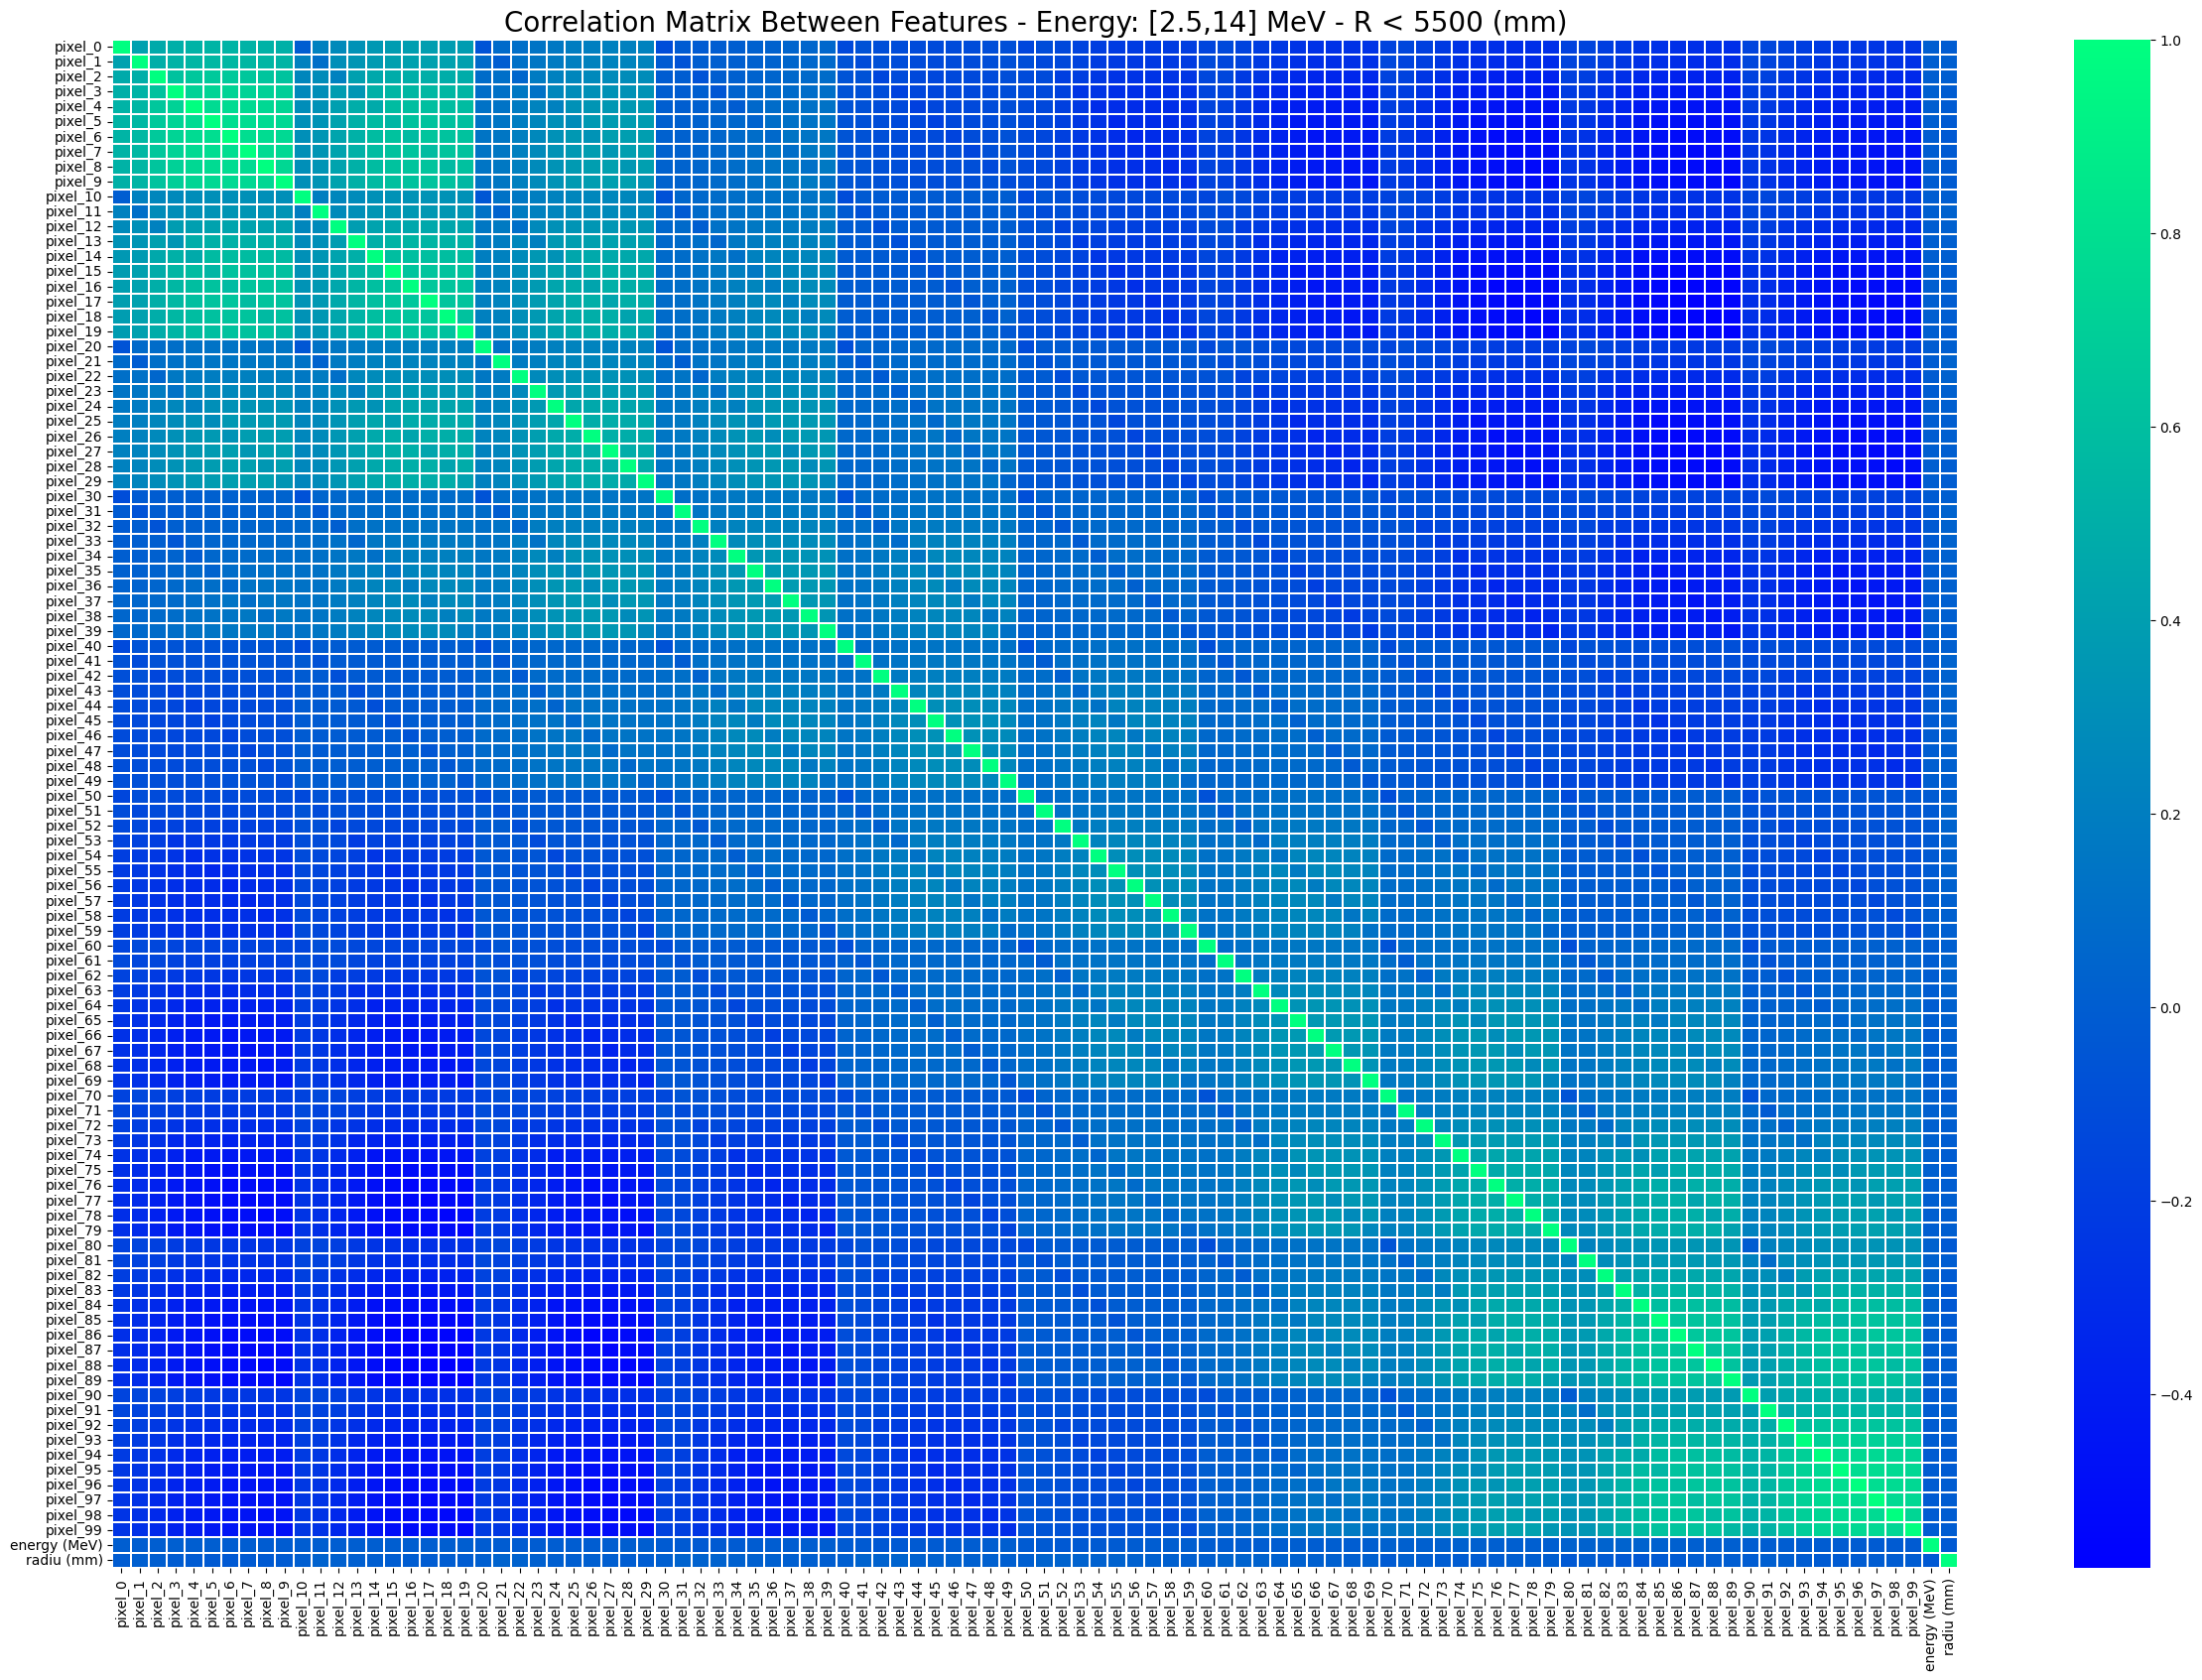

In [33]:
plt.figure(figsize = (30,20))
sn.heatmap(pixel_df.corr(), cmap='winter', linewidths= 0.1)#, vmin = -1, vmax = 1)
plt.title('Correlation Matrix Between Features - Energy: [2.5,14] MeV - R < 5500 (mm)', fontsize = 20)
plt.savefig('figs/First Model/10x10/correlation_matrix(pixels).png', format = 'png', bbox_inches = 'tight')

# 7 - Preprocesar Datos

- Reescalar energia y valores de radio de evento usando normalizer,
- Tratar outliers (datos atipicos) de valores de pixeles usando RobustScaler,

In [11]:
df_pixel =df_read['pixel value'].to_numpy()
df_rad = df_read['event radius (mm)'].to_numpy()
df_energy = df_read['energy (MeV)'].to_numpy()

norm_rad = normalize([df_rad], norm = 'max')[0]
norm_energy = normalize([df_energy], norm = 'max')[0]

#Algo no corre bien con el RobustScaler  -> CLARO! RobustScaler elimina outliers, y la mayoria de pixeles son 0, y considera pixel=1 como outliers ...
#transformer = RobustScaler().fit([df_pixel])
#pixel = transformer.transform([df_pixel])

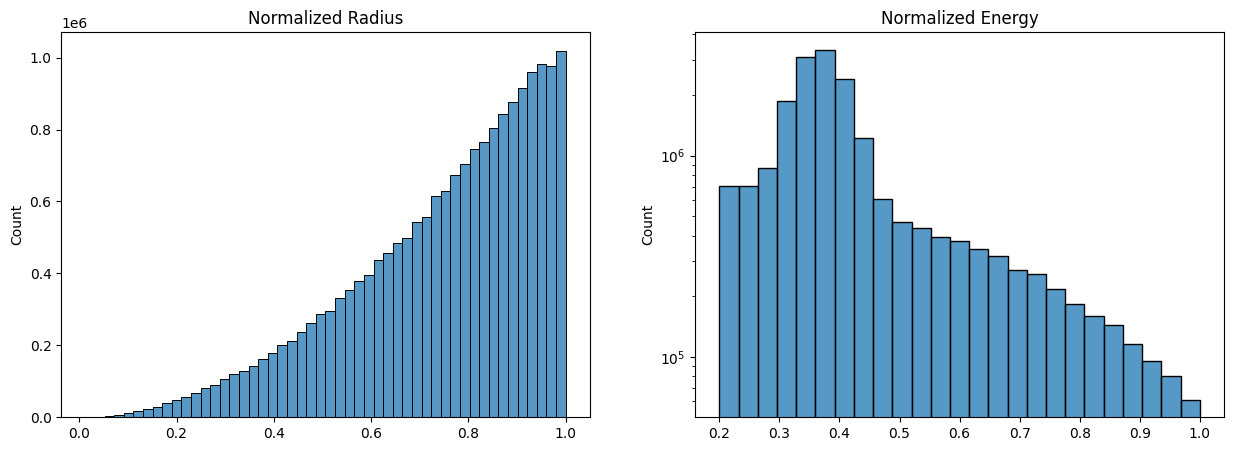

In [12]:
fig, axes = plt.subplots(1, 2,  figsize=(15, 5))

sn.histplot(data = norm_rad, ax=axes[0], bins = 50)
sn.histplot(data = norm_energy, bins = 25, log = True, ax=axes[1])
axes[0].set_title('Normalized Radius', fontsize = 12)
axes[1].set_title('Normalized Energy', fontsize = 12)
plt.savefig('figs/First Model/10x10/Data/norm_rad_ener.png', format = 'png', bbox_inches = 'tight')